# **Realistic Facial Generator: Generative Adversarial Networks to generate older people's faces**

In [1]:
## Imports
from google.colab import drive

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.io as sio
from IPython.display import clear_output

## Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/DeepLearning_2022/Project/Data/'
results_path = '/content/drive/Shared drives/DeepLearning_2022/Project/Results/'

## Import utils
%run "/content/drive/Shared drives/DeepLearning_2022/Project/utils.ipynb"

Mounted at /content/drive


## Create a GAN model

In [2]:
# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=False)##TRUE

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))   
    return out

#  BatchNormnalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=False)##TRUE
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

In [3]:
# 2x(Convolution + BatchNormnalization + ReLU) block for the encoder
class ConvBNReLU2(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,
                          padding = 1, groups = in_channels)
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=1,
                          padding = 0)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=False)##TRUE
    

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn1(self.conv1(out)))  
    out = self.relu(self.bn2(self.conv2(out)))  
    return out

#  2x(BatchNormnalization + ReLU block + Convolution) for the decoder
class BNReLUConv2(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv2, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,
                          padding = 0)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,
                          padding = 1, groups = out_channels)

    self.relu = nn.ReLU(inplace=False)##TRUE

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn1(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv1(out)
    out = self.conv2(self.relu(self.bn2(out)))
    return out

### Generator

In [4]:
class Encoder(nn.Module):
  def __init__(self,base_channels=16, img_channels=3):
    super(Encoder, self).__init__()
    self.base_channels = base_channels

    self.layer1 = ConvBNReLU(img_channels,base_channels,pooling=False)
    self.layer2 = ConvBNReLU2(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU2(base_channels*2,base_channels*4,pooling=True)

  # Generate an image from vector z
  def forward(self,z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    return out

class Decoder(nn.Module):
  def __init__(self,base_channels=16, img_channels=3):
    super(Decoder, self).__init__()
    self.base_channels = base_channels

    self.layer1 = BNReLUConv2(base_channels*4,base_channels*2,pooling=True)
    self.layer2 = BNReLUConv2(base_channels*2,base_channels,pooling=True)
    self.layer3 = BNReLUConv(base_channels,img_channels,pooling=False)
    self.output = nn.Sigmoid()

  # Generate an image from vector z
  def forward(self, z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    return self.output(out)

In [5]:
class Generator(nn.Module):
  def __init__(self,base_channels=16, img_channels=3):
    # input : Image(3x200x200) --> output : Image(3x200x200)
    super(Generator, self).__init__()
    self.base_channels = base_channels

    self.encoder = Encoder(base_channels, img_channels)

    self.residual = nn.Sequential(
        ConvBNReLU(base_channels*4,base_channels*4,pooling=False)
    )

    self.decoder = Decoder(base_channels, img_channels)

  # Generate an image from vector z
  def forward(self,z):
    out= self.encoder(z)
    out = self.residual(out)
    out = self.decoder(out)
    return out

### Discriminator

In [6]:
class Discriminator(nn.Module):
  def __init__(self,base_channels=16, img_channels=3, size_img=(200, 200)):
    # input : Image(3x200x200) --> output : 2 classes (0 Synthesized or young, 1 elderly)
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.base_channels = base_channels
    self.size_img = size_img

    self.encoder = Encoder(base_channels, img_channels)
    self.fc = nn.Sequential(
        nn.Linear((size_img[0]//4)*(size_img[1]//4)*base_channels*4,1)
    )

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.encoder(x)
    out = self.fc(out.view(out.shape[0],-1))
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

## GAN Train Function

### Generator Train

In [7]:
def train_Generetar(G, train_loader, optimizer,
              num_epochs=10, model_name='gan_Gen_prueba.ckpt', device='cpu'):
  
  G = G.to(device)
  G.train() # Set the generator in train mode

  criterion = nn.L1Loss()
  
  t_steps = len(train_loader)
  
  losses_info = Info(num_epochs,gen_params)
  
  for epoch in range(num_epochs):
    # Iterate the dataset
    losses_info.start_stage()
    
    for i, (images,_) in enumerate(train_loader):
      # obtain teh images of this step
      images = images.to(device)
      
      # Forward pass
      # Generate random images with the generator
      images_fake = G(images)
      
      # Use the squared L1 norm to obtain the similarity between young and generate image
      g_loss_reconst = criterion(images_fake, images)
      
      # Generator loss
      G_loss = g_loss_reconst
      
      # We are going to update the discriminator and generator parameters alternatively at each iteration
      optimizer.zero_grad()
      G_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
      optimizer.step()
      
      # print info 
      losses_info.update_stage([G_loss.cpu().item(),g_loss_reconst.cpu().item()])
      
      if (i+1) % mod_print == 0:
        losses_info.print_info(epoch, i, t_steps, all=False)
    if (t_steps) % mod_print != 0:
      losses_info.print_info(epoch, i, t_steps, all=False)
    
    # Save model
    losses_info.save()
    torch.save(G.state_dict(), results_path+ '/' + model_name)
      
  return losses_info

### Discriminator Train

In [8]:
def train_Discriminator(D, train_loader, optimizer,
              num_epochs=10, model_name='gan_Disc_prueba.ckpt', device='cpu'):
  
  D = D.to(device)
  D.train() # Set the discriminator in train mode
  
  train_young = train_loader[0]
  train_elderly = train_loader[1]

  criterion = nn.MSELoss()
  
  t_steps = min(len(train_young), len(train_elderly))
  
  losses_info = Info(num_epochs,disc_params)
  
  for epoch in range(num_epochs):
    # Iterate the dataset
    losses_info.start_stage()

    iter_young = iter(train_young)
    iter_elderly = iter(train_elderly)
    
    for i in range(t_steps):
      # obtain teh images of this step
      images_young, _ = next(iter_young)
      images_young = images_young.to(device)
      images_elderly, _ = next(iter_elderly)
      images_elderly = images_elderly.to(device)
      
      # Forward pass
      # Use the discriminator to obtain the probabilties for elderly and young imee
      prob_young = D(images_young)
      prob_elderly = D(images_elderly)

      # Backward pass
      # Discriminator loss
      d_loss_young = -0.5*torch.log(1-prob_young).mean() 
      d_loss_elderly = -0.5*torch.log(prob_elderly).mean() 

      D_loss = d_loss_young + d_loss_elderly
      
      # We are going to update the discriminator and generator parameters alternatively at each iteration
      optimizer.zero_grad()
      D_loss.backward()
      optimizer.step()
      
      # print info 
      losses_info.update_stage([D_loss.cpu().item(),d_loss_young.cpu().item(),d_loss_elderly.cpu().item()])
      
      if (i+1) % mod_print == 0:
        losses_info.print_info(epoch, i, t_steps, all=False)
    if (t_steps) % mod_print != 0:
      losses_info.print_info(epoch, i, t_steps, all=False)
    
    # Save model
    losses_info.save()
    torch.save(D.state_dict(), results_path+ '/' + model_name)
      
  return losses_info 

### Complet Train

In [9]:
def train_GAN(G, D, train_loader, optimizer_G, optimizer_D,
              num_epochs=10, model_name='gan_prueba', extencion='.ckpt', device='cpu',param=(1,1)):
  
  G = G.to(device)
  G.train() # Set the generator in train mode
  D = D.to(device)
  D.train() # Set the discriminator in train mode
  
  train_young = train_loader[0]
  train_elderly = train_loader[1]
  criterion = nn.L1Loss()
  
  t_steps = min(len(train_young), len(train_elderly))
  
  losses_info = Info(num_epochs,GAN_params)

  p_gLoss_r = param[0]
  p_gLoss_d = param[1]
  
  for epoch in range(num_epochs):
    # Iterate the dataset
    losses_info.start_stage()
    
    update_generator = True
    
    iter_young = iter(train_young)
    iter_elderly = iter(train_elderly)
    
    for i in range(t_steps):
      # obtain teh images of this step
      images_young, _ = next(iter_young)
      images_young = images_young.to(device)
      images_elderly, _ = next(iter_elderly)
      images_elderly = images_elderly.to(device)
      
      # Forward pass
      # Generate fakes images with the generator
      images_fake = G(images_young)

      # Backward pass
      # Use the discriminator to obtain the probabilties for elderly and young/generate imee
      prob_elderly = D(images_elderly)
      prob_fake = D(images_fake)
      
      # Use the criterion to obtain the similarity between young and generate image
      g_loss_reconst = p_gLoss_r*criterion(images_fake, images_young)
      
      # Generator loss
      g_loss_disc = -p_gLoss_d*torch.log(prob_fake).mean()
      G_loss = g_loss_disc + g_loss_reconst 
      # Discriminator loss
      d_loss_elderly = -0.5*torch.log(prob_elderly).mean() 
      d_loss_fake = -0.5*torch.log(1-prob_fake).mean() 
      D_loss = d_loss_elderly + d_loss_fake
      
      # We are going to update the discriminator and generator parameters alternatively at each iteration
      
      if(update_generator):
        # Optimize generator
        # Backward and optimize
        optimizer_G.zero_grad()
        G_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
        optimizer_G.step()
        update_generator = False
      else:           
        # Optimize discriminator
        # Backward and optimize
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()
        update_generator = True
      
      # print info 
      losses_info.update_stage([G_loss.cpu().item(),g_loss_reconst.cpu().item(),g_loss_disc.cpu().item(),
                                D_loss.cpu().item(),d_loss_elderly.cpu().item(),d_loss_fake.cpu().item()])

      if (i+1) % mod_print == 0:
        losses_info.print_info(epoch, i, t_steps, False)
    if (t_steps) % mod_print != 0:
      losses_info.print_info(epoch, i, t_steps, False)
    
    # Save model
    losses_info.save()
    torch.save(G.state_dict(), results_path+ '/' + model_name + '_gen' + extencion)
    torch.save(D.state_dict(), results_path+ '/' + model_name + '_disc' + extencion)
      
  return losses_info 

## Trainning a GAN

### Load a Data

In [10]:
step_size_young = 32
step_size_elderly = 32
clr_type = 'RGB'
resize=(256,256)

if clr_type == 'RGB':
  img_channels = 3
elif clr_type == 'W&B':
  img_channels = 1

train_young, loader_size_young  = obtainData(data_path+'/Data_Young.mat', step_size_young, 2560, clr_type=clr_type, resize=resize)
train_elderly, loader_size_elderly = obtainData(data_path+'/Data_Elderly.mat', step_size_elderly, 2560, clr_type=clr_type, resize=resize)
test_young, loader_size_young_test  = obtainData(data_path+'/Data_Young_test.mat', step_size_young, 2560, clr_type=clr_type, resize=resize)

print("Size Young Data:", loader_size_young)
print("Size Elderly Data:", loader_size_elderly)
print("Size Test Data:", loader_size_young_test)

Size Young Data: 2560
Size Elderly Data: 2560
Size Test Data: 256


### Trainning Generator

In [ ]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(64,img_channels=img_channels)
print("Genetator Parameters:", compute_model_params(gan_gen))

# Initialize indepdent optimizer for both networks
learning_rate = .001
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate, weight_decay=1e-3)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Devise:",device)
print("Strat Trainning")
loss_info_g = train_Generetar(gan_gen, train_young, optimizer_gen, num_epochs=5, model_name='gan_Gen_basic_model_1.ckpt', device=device)

Genetator Parameters: 683011
Devise: cuda:0
Strat Trainning
Epoch [1/5], Step [5/41], Gen. Loss: 0.1545
Epoch [1/5], Step [10/41], Gen. Loss: 0.1103
Epoch [1/5], Step [15/41], Gen. Loss: 0.0896
Epoch [1/5], Step [20/41], Gen. Loss: 0.0782
Epoch [1/5], Step [25/41], Gen. Loss: 0.0709
Epoch [1/5], Step [30/41], Gen. Loss: 0.0659
Epoch [1/5], Step [35/41], Gen. Loss: 0.0613
Epoch [1/5], Step [40/41], Gen. Loss: 0.0582
Epoch [1/5], Step [41/41], Gen. Loss: 0.0577
Epoch [2/5], Step [5/41], Gen. Loss: 0.0323
Epoch [2/5], Step [10/41], Gen. Loss: 0.0337
Epoch [2/5], Step [15/41], Gen. Loss: 0.0345
Epoch [2/5], Step [20/41], Gen. Loss: 0.0339
Epoch [2/5], Step [25/41], Gen. Loss: 0.0331
Epoch [2/5], Step [30/41], Gen. Loss: 0.0327
Epoch [2/5], Step [35/41], Gen. Loss: 0.0326
Epoch [2/5], Step [40/41], Gen. Loss: 0.0330
Epoch [2/5], Step [41/41], Gen. Loss: 0.0330
Epoch [3/5], Step [5/41], Gen. Loss: 0.0318
Epoch [3/5], Step [10/41], Gen. Loss: 0.0306
Epoch [3/5], Step [15/41], Gen. Loss: 0.030

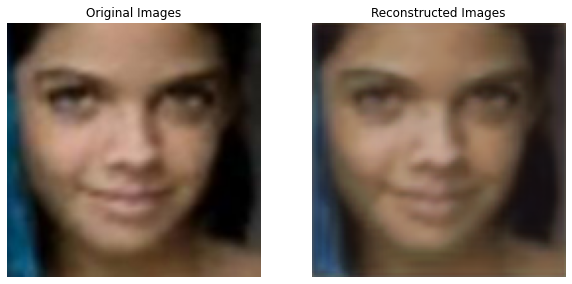

In [ ]:
#loss_info_g.print_all_info()
images, _ = next(iter(train_young))
images = images.to(device)
gan_gen.load_state_dict(torch.load(results_path+'gan_Gen_basic_model_1.ckpt',map_location=torch.device(device)))
show_Result(gan_gen, images[:1])

### Trainning Discriminator

In [ ]:
# Define Geneartor and Discriminator networks
gan_disc = Discriminator(img_channels=img_channels, size_img = resize)
print("Discriminator Parameters:", compute_model_params(gan_disc))

# Initialize indepdent optimizer for both networks
learning_rate = .0001
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate, weight_decay=1e-3)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Devise:",device)
print("Strat Trainning")
loss_info_d = train_Discriminator(gan_disc, (train_young,train_elderly), optimizer_disc, num_epochs=5, model_name='gan_Disc_basic_model_1.ckpt', device='cpu')

Discriminator Parameters: 69441
Devise: cuda:0
Strat Trainning
Epoch [1/5], Step [5/41], Disc. Loss: 0.6392
Epoch [1/5], Step [10/41], Disc. Loss: 0.5814
Epoch [1/5], Step [15/41], Disc. Loss: 0.5350
Epoch [1/5], Step [20/41], Disc. Loss: 0.5029
Epoch [1/5], Step [25/41], Disc. Loss: 0.4727
Epoch [1/5], Step [30/41], Disc. Loss: 0.4508
Epoch [1/5], Step [35/41], Disc. Loss: 0.4384
Epoch [1/5], Step [40/41], Disc. Loss: 0.4162
Epoch [1/5], Step [41/41], Disc. Loss: 0.4126
Epoch [2/5], Step [5/41], Disc. Loss: 0.2549
Epoch [2/5], Step [10/41], Disc. Loss: 0.2427
Epoch [2/5], Step [15/41], Disc. Loss: 0.2309
Epoch [2/5], Step [20/41], Disc. Loss: 0.2281
Epoch [2/5], Step [25/41], Disc. Loss: 0.2206
Epoch [2/5], Step [30/41], Disc. Loss: 0.2156
Epoch [2/5], Step [35/41], Disc. Loss: 0.2109
Epoch [2/5], Step [40/41], Disc. Loss: 0.2061
Epoch [2/5], Step [41/41], Disc. Loss: 0.2048
Epoch [3/5], Step [5/41], Disc. Loss: 0.1385
Epoch [3/5], Step [10/41], Disc. Loss: 0.1365
Epoch [3/5], Step [1

In [ ]:
#loss_info_d.print_all_info()

images_young, _ = next(iter(train_young))
images_elderly, _ = next(iter(train_elderly))
gan_disc.load_state_dict(torch.load(results_path+'gan_Disc_basic_model_1.ckpt'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

accuracy_Disc(gan_disc, images_young, images_elderly, device=device)

Accuracy: 98.44%


### Trainning GAN

In [12]:
# Define Geneartor and Discriminator networks

gan_gen = Generator(64,img_channels=img_channels)
print("Genetator Parameters:", compute_model_params(gan_gen))
gan_disc = Discriminator(img_channels=img_channels, size_img=resize)
print("Discriminator Parameters:", compute_model_params(gan_disc))

# Initialize indepdent optimizer for both networks
learning_rate_gen = .001
learning_rate_disc = .0001
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate_gen, weight_decay=1e-3)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate_disc, weight_decay=1e-3)


# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
print("Start Trainning")
param = (0.1,.01) # (parameter Loss reconstruction, parameter Loss Discriminator)

loss_info = train_GAN(gan_gen,gan_disc, (train_young,train_elderly), optimizer_gen, optimizer_disc,
                      num_epochs=20, model_name='gan_basic_model_2_c', device=device, param=param)

Genetator Parameters: 683011
Discriminator Parameters: 266049
Device: cuda:0
Start Trainning
Epoch [1/20], Step [5/80], Gen. Loss: 0.0509, Disc. Loss: 1.5923
Epoch [1/20], Step [10/80], Gen. Loss: 0.0360, Disc. Loss: 1.6877
Epoch [1/20], Step [15/80], Gen. Loss: 0.0328, Disc. Loss: 1.4245
Epoch [1/20], Step [20/80], Gen. Loss: 0.0358, Disc. Loss: 1.4250
Epoch [1/20], Step [25/80], Gen. Loss: 0.0320, Disc. Loss: 1.3243
Epoch [1/20], Step [30/80], Gen. Loss: 0.0291, Disc. Loss: 1.2530
Epoch [1/20], Step [35/80], Gen. Loss: 0.0293, Disc. Loss: 1.1793
Epoch [1/20], Step [40/80], Gen. Loss: 0.0284, Disc. Loss: 1.1374
Epoch [1/20], Step [45/80], Gen. Loss: 0.0268, Disc. Loss: 1.1291
Epoch [1/20], Step [50/80], Gen. Loss: 0.0259, Disc. Loss: 1.1243
Epoch [1/20], Step [55/80], Gen. Loss: 0.0253, Disc. Loss: 1.1193
Epoch [1/20], Step [60/80], Gen. Loss: 0.0244, Disc. Loss: 1.1010
Epoch [1/20], Step [65/80], Gen. Loss: 0.0240, Disc. Loss: 1.0713
Epoch [1/20], Step [70/80], Gen. Loss: 0.0242, Dis

In [13]:
loss_info.print_all_info()

Epoch [1/20], Gen. Loss: 0.0240, Disc. Loss: 1.0099
	Gen.: Loss reconst: 0.0101 (42%), Loss disc: 0.0139 (58%)
	Disc.: Loss elderly: 0.5311 (53%), Loss fake: 0.4788 (47%)
Epoch [2/20], Gen. Loss: 0.0244, Disc. Loss: 0.7757
	Gen.: Loss reconst: 0.0108 (44%), Loss disc: 0.0136 (56%)
	Disc.: Loss elderly: 0.4543 (59%), Loss fake: 0.3214 (41%)
Epoch [3/20], Gen. Loss: 0.0289, Disc. Loss: 0.9302
	Gen.: Loss reconst: 0.0113 (39%), Loss disc: 0.0175 (61%)
	Disc.: Loss elderly: 0.5235 (56%), Loss fake: 0.4067 (44%)
Epoch [4/20], Gen. Loss: 0.0333, Disc. Loss: 0.7125
	Gen.: Loss reconst: 0.0115 (34%), Loss disc: 0.0218 (66%)
	Disc.: Loss elderly: 0.4339 (61%), Loss fake: 0.2787 (39%)
Epoch [5/20], Gen. Loss: 0.0320, Disc. Loss: 0.7814
	Gen.: Loss reconst: 0.0112 (35%), Loss disc: 0.0208 (65%)
	Disc.: Loss elderly: 0.4164 (53%), Loss fake: 0.3650 (47%)
Epoch [6/20], Gen. Loss: 0.0364, Disc. Loss: 0.6376
	Gen.: Loss reconst: 0.0117 (32%), Loss disc: 0.0246 (68%)
	Disc.: Loss elderly: 0.3657 (57%)

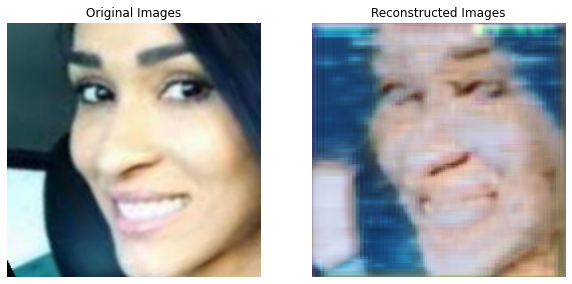

In [15]:
images, _ = next(iter(test_young))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
images = images.to(device)
gan_gen = Generator(64,img_channels=img_channels)
gan_gen.to(device)
gan_gen.load_state_dict(torch.load(results_path+'gan_basic_model_2_c_gen.ckpt',map_location=torch.device(device)))
show_Result(gan_gen, images[:1])

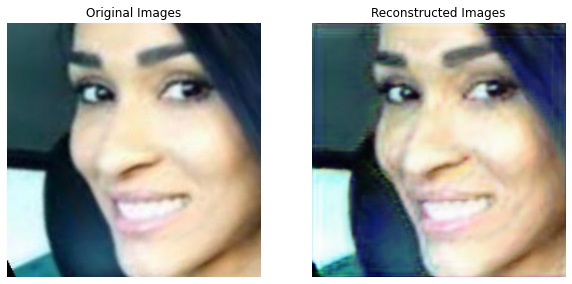

In [16]:
gan_gen.load_state_dict(torch.load(results_path+'gan_basic_model_1_b_gen.ckpt',map_location=torch.device(device)))
show_Result(gan_gen, images[:1])

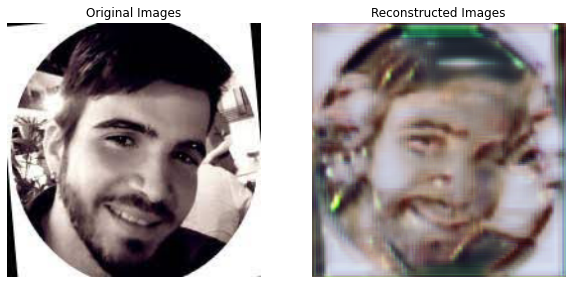

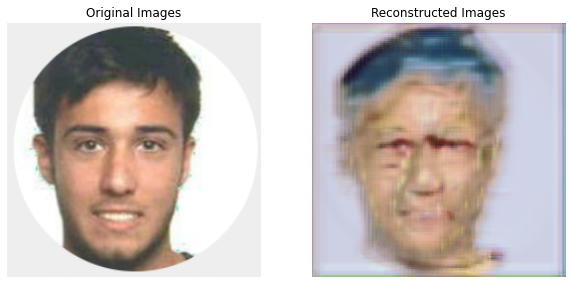

In [23]:
to_tensor_tf = tf.Compose([
          tf.Resize((256,256)),
          tf.ToTensor(), 
          ])
profe1 = Image.open(data_path + 'profe1.jpg')
image_porfe1 = to_tensor_tf(profe1)
image_porfe1 = image_porfe1.unsqueeze(0)

profe2 = Image.open(data_path + 'profe2.png')
image_porfe2 = to_tensor_tf(profe2)
image_porfe2 = image_porfe2.unsqueeze(0)
images_profes = torch.cat((image_porfe1, image_porfe2), 0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
images_profes = images_profes.to(device)
gan_gen = Generator(64,img_channels=3)
gan_gen.to(device)
gan_gen.load_state_dict(torch.load(results_path+'gan_basic_model_2_c_gen.ckpt',map_location=torch.device(device)))
show_Result(gan_gen, images_profes[:1])
show_Result(gan_gen, images_profes[1:])